### This notebook perform modelling with CPM-scaled = log(spend)/log(impressions)

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import load_pickle, save_pickle
from datetime import datetime, timedelta
import cleaning, utils
from scipy import stats
import seaborn as sb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mean_squared_error
from sklearn.metrics import make_scorer, f1_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
import importlib

importlib.reload(utils)

<module 'utils' from 'Y:\\Internship\\SoMin\\Notebook\\src\\utils.py'>

In [2]:
df = pd.read_csv('Y:/Internship/SoMin/data/df_cpm_scaled_valid_img.csv')
df.shape

(30966, 47)

### Append img and text features

In [3]:
text_features = pd.read_pickle('Y:/Internship/SoMin/clean/text_features_trial1_0206.pkl')
image_features = pd.read_pickle('Y:/Internship/SoMin/clean/image_features_trial1_0206.pkl')
print(text_features.shape)
print(image_features.shape)

(30432, 385)
(29761, 769)


In [1]:
text_features.columns

NameError: name 'text_features' is not defined

In [ ]:
image_features.columns

In [6]:
df = df[df.currency=='USD'].reset_index(drop=True) # USD only
df = df[df.country=='US'].reset_index(drop=True) # USD only
df.shape

(30852, 47)

In [7]:
df = df[df.ad_id.isin(image_features.ad_id.tolist())].reset_index(drop=True) # retrieved images
df.shape

(29676, 47)

In [8]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'search_term', 'country', 'page_id',
       'page_name', 'ad_id', 'ad_creation_date', 'ad_creation_month',
       'delivery_start', 'delivery_stop', 'delivery_period', 'ad_url',
       'ad_body', 'uses_multi_body', 'link_caption', 'uses_multi_capt',
       'link_title', 'uses_multi_title', 'link_description', 'uses_multi_desc',
       'language', 'uses_multi_lang', 'funded_by', 'currency', 'min_spend',
       'max_spend', 'min_impressions', 'max_impressions', 'min_audience_size',
       'max_audience_size', 'impressions', 'spend', 'CPM', 'CPM2', 'facebook',
       'instagram', 'messenger', 'audience_network', 'demographic_dist',
       'spend_per_day', 'impressions_per_day', 'impressions_per_day_log',
       'CPM_scaled', 'CPM_scaled_sqrt', 'text_length_score',
       'text_percentage'],
      dtype='object')

In [9]:
text_image_features = text_features.merge(image_features, on='ad_id', how='inner')
text_image_features

,ad_id,txt_a0,txt_a1,txt_a2,txt_a3,txt_a4,txt_a5,txt_a6,txt_a7,txt_a8,...,img758,img759,img760,img761,img762,img763,img764,img765,img766,img767
0,762749274711708,-0.184409,0.092720,0.234229,0.244633,0.133959,-0.034743,-0.414326,0.169170,0.161987,...,0.465630,0.002484,-0.085118,0.052690,-0.236282,-0.064323,0.325325,-0.202712,-0.088441,-0.287930
1,563054608471314,-0.184409,0.092720,0.234229,0.244633,0.133959,-0.034743,-0.414326,0.169170,0.161987,...,0.465630,0.002484,-0.085118,0.052690,-0.236282,-0.064323,0.325325,-0.202712,-0.088441,-0.287930
2,930566127614072,0.076499,-0.013126,-0.133957,-0.238189,0.210767,0.140465,-0.308346,-0.018898,-0.037311,...,-0.179992,0.032911,0.030026,-0.294595,-0.231033,-0.003755,-0.199238,-0.027423,-0.078111,-0.131632
3,738864343939155,0.095724,-0.046410,-0.321614,0.034098,0.072352,0.331428,0.310781,-0.053475,0.043906,...,-0.146833,-0.075014,-0.054048,-0.222878,0.120308,-0.341486,-0.292918,-0.210843,0.045422,-0.129597
4,512240050437223,0.140352,0.102625,-0.044546,0.140429,0.093042,0.280933,0.299975,0.018833,0.110578,...,-0.021403,0.025870,-0.075021,-0.094134,0.051662,-0.187134,-0.271364,-0.129058,-0.115162,0.132305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31468,381289572628044,0.311172,-0.154511,-0.035533,-0.154961,0.025548,-0.134334,-0.118996,0.206683,-0.042514,...,0.112608,-0.019068,-0.082013,-0.202433,-0.156729,0.015124,-0.232641,-0.035432,-0.121599,-0.171165
31469,517753845398018,0.311172,-0.154511,-0.035533,-0.154961,0.025548,-0.134334,-0.118996,0.206683,-0.042514,...,-0.043676,-0.007365,-0.020420,-0.408333,-0.079077,0.191462,-0.339416,-0.337108,-0.168544,-0.264438
31470,1251766551633027,0.311172,-0.154511,-0.035533,-0.154961,0.025548,-0.134334,-0.118996,0.206683,-0.042514,...,-0.036252,-0.033005,-0.099844,-0.245278,-0.182185,-0.055517,-0.100192,-0.015562,-0.046616,0.002111
31471,205891737021220,0.311172,-0.154511,-0.035533,-0.154961,0.025548,-0.134334,-0.118996,0.206683,-0.042514,...,0.123096,-0.014946,-0.132246,-0.349340,-0.189837,0.163440,-0.058997,-0.095573,-0.131043,0.032312


### Drop index with invalid image

In [10]:
# IMG_DIR = "Y:/Internship/SoMin/Image"
# img_file = os.listdir(IMG_DIR)

In [11]:
# img_file[1][:-4]

In [12]:
# df['ad_body'].fillna("", inplace=True)

In [13]:
# def text_char_optimality(text):
#     """
#     Why?
#     - https://sproutsocial.com/insights/social-media-character-counter/
#     - https://baymard.com/blog/line-length-readability
#     """
#     if len(text) <= 50:
#         return 5
#     if len(text) <= 100:
#         return 4
#     if len(text) <= 150:
#         return 3
#     if len(text) <= 200:
#         return 2
#     return 1

# df['text_length_score'] = df['ad_body'].apply(lambda x: text_char_optimality(x))

In [14]:
# df.shape

In [15]:
# df = df[(np.abs(stats.zscore(df['delivery_period'])) < 2)]
# df.shape

In [16]:
# df['delivery_period'] = np.log(df['delivery_period'])

In [15]:
# df['CPM_scaled_sqrt_bin'] = pd.cut(x=df['CPM_scaled_sqrt'], bins=[0, 10, 20, 30, 40, 100], labels=[0,1,2,3,4], ordered=True)

In [10]:
df.shape

(29676, 47)

In [11]:
df.dropna(subset=['CPM_scaled_sqrt'], inplace=True)

In [12]:
df.shape

(29651, 47)

In [13]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'search_term', 'country', 'page_id',
       'page_name', 'ad_id', 'ad_creation_date', 'ad_creation_month',
       'delivery_start', 'delivery_stop', 'delivery_period', 'ad_url',
       'ad_body', 'uses_multi_body', 'link_caption', 'uses_multi_capt',
       'link_title', 'uses_multi_title', 'link_description', 'uses_multi_desc',
       'language', 'uses_multi_lang', 'funded_by', 'currency', 'min_spend',
       'max_spend', 'min_impressions', 'max_impressions', 'min_audience_size',
       'max_audience_size', 'impressions', 'spend', 'CPM', 'CPM2', 'facebook',
       'instagram', 'messenger', 'audience_network', 'demographic_dist',
       'spend_per_day', 'impressions_per_day', 'impressions_per_day_log',
       'CPM_scaled', 'CPM_scaled_sqrt', 'text_length_score',
       'text_percentage'],
      dtype='object')

In [14]:
df.shape

(29651, 47)

In [15]:
text_image_features.shape

(31473, 1153)

### Potential predictors <br>
- search-term: need embedding to capture meaning? (X)
+ ad-creation-month (used now)
+ delivery-period (used now)
- ad-body: need text processing (used now)
+ length of text (used now)
- Image text coverage (used now)
- ad-image (used now)
- like, follow (X)
- targeting type (X)

In [16]:
feature_set = df[['ad_id','delivery_period','text_length_score','text_percentage',
                  'facebook','instagram','messenger','audience_network','CPM_scaled_sqrt']].merge(right=text_image_features, on='ad_id', how='inner')

In [17]:
feature_set

,ad_id,delivery_period,text_length_score,text_percentage,facebook,instagram,messenger,audience_network,CPM_scaled_sqrt,txt_a0,...,img758,img759,img760,img761,img762,img763,img764,img765,img766,img767
0,762749274711708,1.386294,1,19.610181,1,0,0,0,19.728580,-0.184409,...,0.465630,0.002484,-0.085118,0.052690,-0.236282,-0.064323,0.325325,-0.202712,-0.088441,-0.287930
1,563054608471314,1.386294,1,19.610181,1,0,0,0,22.784619,-0.184409,...,0.465630,0.002484,-0.085118,0.052690,-0.236282,-0.064323,0.325325,-0.202712,-0.088441,-0.287930
2,930566127614072,1.791759,1,20.669841,1,1,0,0,19.503617,0.076499,...,-0.179992,0.032911,0.030026,-0.294595,-0.231033,-0.003755,-0.199238,-0.027423,-0.078111,-0.131632
3,738864343939155,2.772589,1,22.993093,1,0,0,0,15.701232,0.095724,...,-0.146833,-0.075014,-0.054048,-0.222878,0.120308,-0.341486,-0.292918,-0.210843,0.045422,-0.129597
4,512240050437223,2.944439,1,23.020000,1,1,0,0,21.179027,0.140352,...,-0.021403,0.025870,-0.075021,-0.094134,0.051662,-0.187134,-0.271364,-0.129058,-0.115162,0.132305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34992,381289572628044,3.367296,1,7.028637,1,1,0,0,15.994003,0.311172,...,0.112608,-0.019068,-0.082013,-0.202433,-0.156729,0.015124,-0.232641,-0.035432,-0.121599,-0.171165
34993,517753845398018,3.367296,1,17.986111,1,1,0,0,20.082258,0.311172,...,-0.043676,-0.007365,-0.020420,-0.408333,-0.079077,0.191462,-0.339416,-0.337108,-0.168544,-0.264438
34994,1251766551633027,3.367296,1,8.209660,1,1,0,0,22.690707,0.311172,...,-0.036252,-0.033005,-0.099844,-0.245278,-0.182185,-0.055517,-0.100192,-0.015562,-0.046616,0.002111
34995,205891737021220,0.000000,1,14.993590,1,1,0,0,18.385652,0.311172,...,0.123096,-0.014946,-0.132246,-0.349340,-0.189837,0.163440,-0.058997,-0.095573,-0.131043,0.032312


In [18]:
X = feature_set.drop(['ad_id', 'CPM_scaled_sqrt'], axis=1)
y = feature_set[['CPM_scaled_sqrt']]

In [19]:
print('Shape of X:\t', X.shape)
print('Shape of y:\t', y.shape)

Shape of X:	 (34997, 1159)
Shape of y:	 (34997, 1)


# Visualization

(array([  327.,  1203.,  2640.,  6101., 11492.,  9177.,  3055.,   729.,
          217.,    56.]),
 array([ 1.5472947 ,  5.84393213, 10.14056955, 14.43720698, 18.7338444 ,
        23.03048183, 27.32711925, 31.62375668, 35.9203941 , 40.21703153,
        44.51366895]),
 <BarContainer object of 10 artists>)

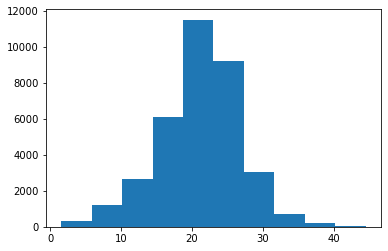

In [20]:
plt.hist(y)

The distribution looks normal, but it is good for regression problem. Classification problem may prefer even distribution

In [21]:
# 60-20-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [22]:
print(X_train.shape)
# print(X_val.shape)
print(X_test.shape)

(27997, 1159)
(7000, 1159)


## Model

In [23]:
def report(y_train, y_train_pred, y_test, y_test_pred):
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print("Root mean square error train:\t", rmse_train)
    print("Root mean square error test:\t", rmse_test)
    print("Mean value of y_train_pred:\t", np.mean(y_train_pred))
    print("Mean value of y_test_pred:\t", np.mean(y_test_pred))
    print("Ratio train:\t", rmse_train/np.mean(y_train_pred))
    print("Ratio test:\t", rmse_test/np.mean(y_test_pred))

# Linear Regression

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

report(y_train, y_train_pred, y_test, y_test_pred)

Root mean square error train:	 5.359339469496698
Root mean square error test:	 5.6708877428638065
Mean value of y_train_pred:	 21.20673484688029
Mean value of y_test_pred:	 21.223483340443114
Ratio train:	 0.2527187475202061
Ratio test:	 0.26719872755559676


# XGB Regressor

In [24]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

report(y_train, y_train_pred, y_test, y_test_pred)

C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Root mean square error train:	 4.185188908624585
Root mean square error test:	 5.332050657144101
Mean value of y_train_pred:	 21.206638
Mean value of y_test_pred:	 21.17805
Ratio train:	 0.1973527742718202
Ratio test:	 0.2517725138471376


# SVR

In [25]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

report(y_train, y_train_pred, y_test, y_test_pred)

C:\Users\root\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Root mean square error train:	 5.520362869627614
Root mean square error test:	 5.648365004519244
Mean value of y_train_pred:	 21.52448676061499
Mean value of y_test_pred:	 21.5195851081366
Ratio train:	 0.2564689662997515
Ratio test:	 0.26247555313617943


In [26]:
feature_set.columns

Index(['ad_id', 'delivery_period', 'text_length_score', 'text_percentage',
       'facebook', 'instagram', 'messenger', 'audience_network',
       'CPM_scaled_sqrt', 'txt_a0',
       ...
       'img758', 'img759', 'img760', 'img761', 'img762', 'img763', 'img764',
       'img765', 'img766', 'img767'],
      dtype='object', length=1161)

In [27]:
feature_set.to_csv('Y:/Internship/SoMin/clean/feature_set_regression.csv')
pd.to_pickle(feature_set, 'Y:/Internship/SoMin/clean/feature_set_regression.pkl')